### **Objective**: Predict whether it will rain tomorrow in Australia based on today's weather data.

### Table of Contents

* Loading preprocessed data
* Train Logistic regression
* Train Decision Tree classifier
* Hyperparameter optimization with Random Search
* Traing XGBoost classifier
* Train LightGBM classifier
* Hyperparameter optimization with Hyperopt
* Conclusions


Results and conclusion

### Imports

In [1]:
import opendatasets as od
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc


import joblib

### Loading preprocessed data

In [2]:
preprocessing = joblib.load('data/preprocessing.joblib')

imputer = preprocessing['imputer']
scaler = preprocessing['scaler']
encoder = preprocessing['encoder']
input_cols = preprocessing['input_cols']
target_col = preprocessing['target_col']
numeric_cols = preprocessing['numeric_cols']
categorical_cols = preprocessing['categorical_cols']
encoded_cols = preprocessing['encoded_cols']

In [3]:
train_inputs = pd.read_parquet('data/parquet/train_inputs.parquet')
val_inputs = pd.read_parquet('data/parquet/val_inputs.parquet')
test_inputs = pd.read_parquet('data/parquet/test_inputs.parquet')

train_targets = pd.read_parquet('data/parquet/train_targets.parquet')[target_col]
val_targets = pd.read_parquet('data/parquet/val_targets.parquet')[target_col]
test_targets = pd.read_parquet('data/parquet/test_targets.parquet')[target_col]

In [4]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


In [5]:
train_inputs.head(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,Albury,0.516509,0.517241,0.001617,0.064199,0.532098,W,0.294574,W,WNW,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Albury,0.375000,0.559387,0.000000,0.064199,0.532098,WNW,0.294574,NNW,WSW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Albury,0.504717,0.570881,0.000000,0.064199,0.532098,WSW,0.310078,W,WSW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Albury,0.417453,0.614943,0.000000,0.064199,0.532098,NE,0.139535,SE,E,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Albury,0.613208,0.697318,0.002695,0.064199,0.532098,W,0.271318,ENE,NW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
train_targets.head(5)

0    No
1    No
2    No
3    No
4    No
Name: RainTomorrow, dtype: object

### Logistic Regression
 
Logistic regression is a commonly used technique for solving binary classification problems

Here is a visual summary of logistic regression model structure:

<img src="https://i.imgur.com/YMaMo5D.png" width="480">


The sigmoid function applied to a linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">


To train a logistic regression model, we can use the `LogisticRegression` from Scikit-learn

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
lg_model = LogisticRegression(solver='liblinear')
lg_model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

#### Forecasting & evaluation

In [9]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [10]:
train_preds = lg_model.predict(X_train)

Let`s take a look on model predictions

In [11]:
print('Train data target / prediction')
[[p, t] for (p, t) in zip(train_targets[:10], train_preds[:10])]

Train data target / prediction


[['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['No', 'No'],
 ['Yes', 'No'],
 ['No', 'No']]

The numbers below indicate the probabilities for the target classes `No` and `Yes`.

In [12]:
train_probs = lg_model.predict_proba(X_train)
train_probs[:10]
# No/yes prob

array([[0.94462531, 0.05537469],
       [0.94105924, 0.05894076],
       [0.96092455, 0.03907545],
       [0.98907678, 0.01092322],
       [0.72267049, 0.27732951],
       [0.87634734, 0.12365266],
       [0.93927695, 0.06072305],
       [0.97942411, 0.02057589],
       [0.7759601 , 0.2240399 ],
       [0.96196271, 0.03803729]])

Let's see model performance on `training`, `validation` and `test` data

In [13]:
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 85.20%


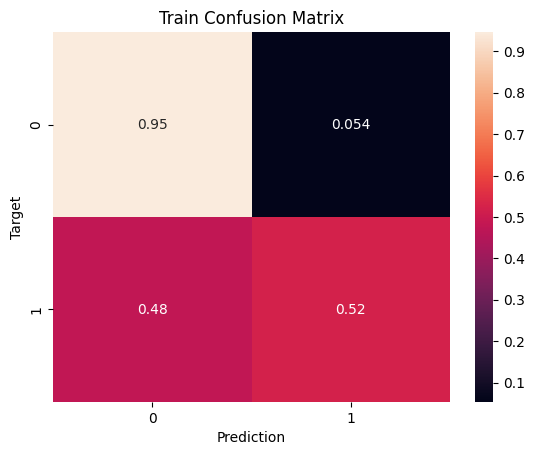

In [14]:
train_preds = predict_and_plot(lg_model, X_train, train_targets, 'Train')

Accuracy: 85.39%


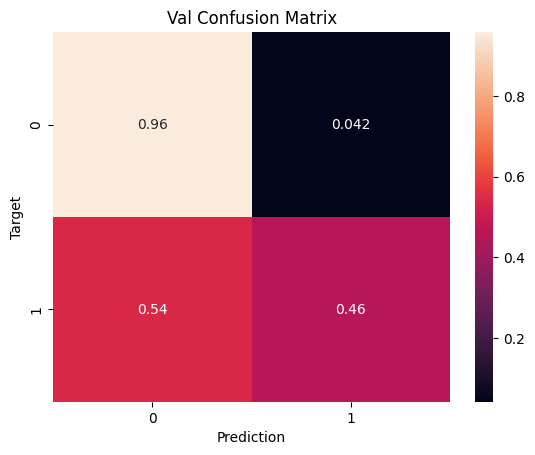

In [15]:
val_preds = predict_and_plot(lg_model, X_val, val_targets, 'Val')

Accuracy: 84.22%


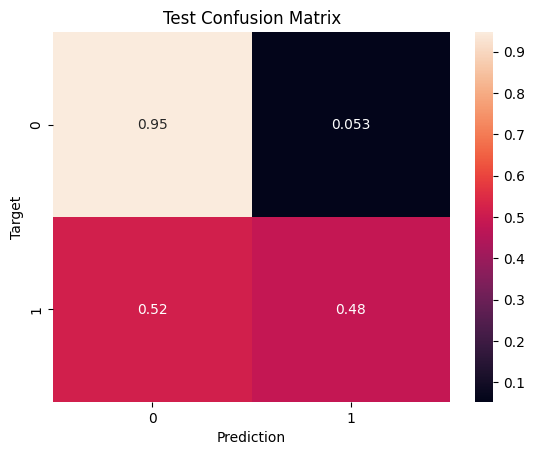

In [16]:
test_preds = predict_and_plot(lg_model, X_test, test_targets, 'Test')

The accuracy on test and validation sets exceeds 84%, which indicates that model is good at generalizing data it has not seen before

Now let's create two models: one that guesses randomly and one that always returns 'No'. Both of these models completely ignore the input data they are given


In [17]:
def random_guess(inputs):
    return np.random.choice(["No", "Yes"], len(inputs))

def all_no(inputs):
    return np.full(len(inputs), "No")

In [18]:
print("Random model Accuracy: {:.2f}%".format(accuracy_score(test_targets, random_guess(X_test)) * 100))
print("All No model Accuracy: {:.2f}%".format(accuracy_score(test_targets, all_no(X_test)) * 100))


Random model Accuracy: 49.61%
All No model Accuracy: 77.34%


Trivial model that always says 'No' has the accuracy 77%, so we can see that using the Accuracy metric doesn't give us a very accurate estimate of the model.

However, if we use the `F1 score`, we get a much more accurate results. 
It combines precision and recall to create a single value that balances between the two

- **Precision**: Percentage of correctly predicted positive examples among all examples predicted as positive.
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  where $$ TP $$ (True Positives) is the number of correctly predicted positive cases, $$ FP $$ (False Positives) is the number of incorrectly predicted positive cases.

- **Completeness (Recall)**: Percentage of correctly predicted positive examples among all real positive examples.
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  where $$ FN $$ (False Negatives) is the number of incorrectly predicted negative cases.


The F1 metric is calculated as a harmonic mean between accuracy and completeness:
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [19]:
f1_score(train_targets, train_preds, pos_label='Yes')

0.6110604516440487

In [20]:
def get_f1_score(model, inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label='Yes')
  print(f"F1 score {name}: {f1_score_:.2f}")

In [21]:
get_f1_score(lg_model, X_train, train_targets, 'Training')
get_f1_score(lg_model, X_val, val_targets, 'Validation')
get_f1_score(lg_model, X_test, test_targets, 'Test')

F1 score Training: 0.61
F1 score Validation: 0.57
F1 score Test: 0.58


In [22]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label='Yes')

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


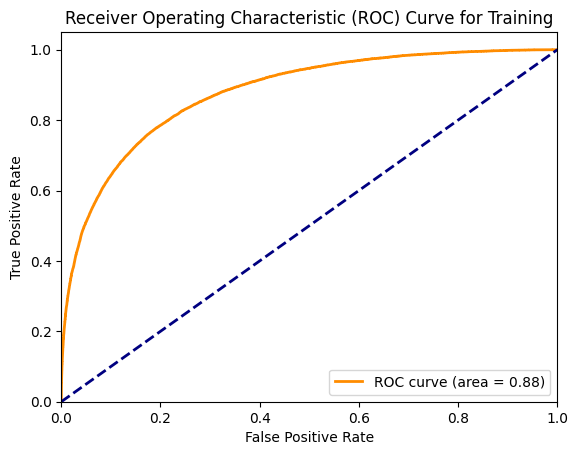

AUROC for Validation: 0.87


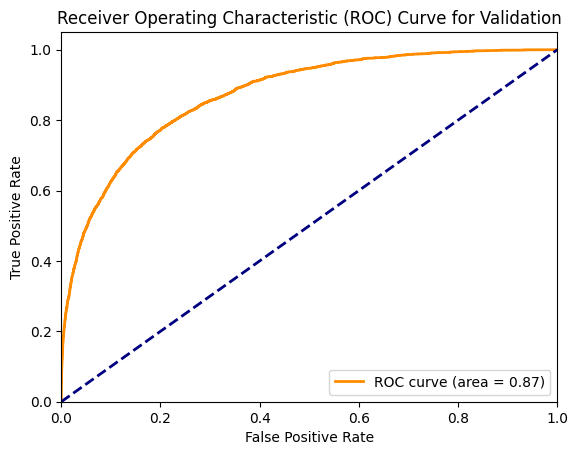

In [23]:
compute_auroc_and_build_roc(lg_model, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(lg_model, X_val, val_targets, 'Validation')

Let's create `results_df` dataframe to save achived metrics for this and next experiments

In [183]:
results_df = pd.DataFrame({'model': ['Logistic Regression'],
                    'f1_score_train': [0.61], 'f1_score_val': [0.57], 
                    'roc_auc_train' : [0.88], 'roc_auc_val' : [0.87], 
                    'accuracy_train' : [0.85], 'accuracy_val' : [0.85]})

results_df

,model,f1_score_train,f1_score_val,roc_auc_train,roc_auc_val,accuracy_train,accuracy_val
0,Logistic Regression,0.61,0.57,0.88,0.87,0.85,0.85


### Decision Tree

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

<img src="https://i.imgur.com/qSH4lqz.png" width="480">


In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

Let's evaluate the decision tree model using accuracy score and f1 score

In [26]:
# Training set
dt_model.score(X_train, train_targets)

0.9999795893374699

In [27]:
# Validation set
dt_model.score(X_val, val_targets)

0.7935514073380537

In [28]:
get_f1_score(dt_model, X_train, train_targets, 'Training')
get_f1_score(dt_model, X_val, val_targets, 'Validation')
get_f1_score(dt_model, X_test, test_targets, 'Test')

F1 score Training: 1.00
F1 score Validation: 0.50
F1 score Test: 0.51


AUROC for DecisionTreeClassifier on Train data: 1.00


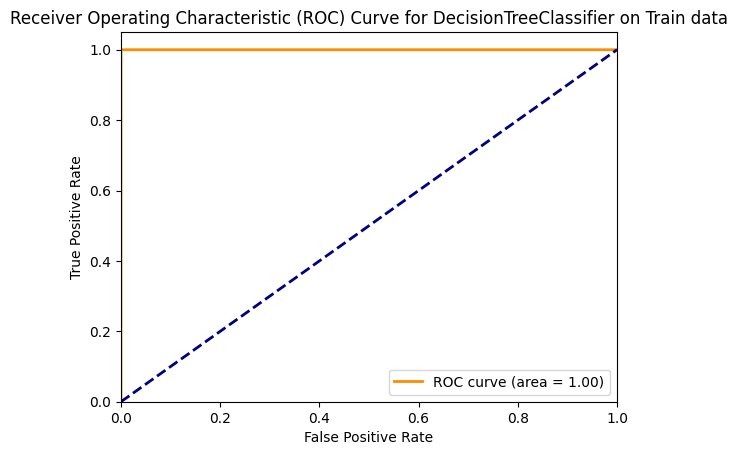

In [139]:
compute_auroc_and_build_roc(dt_model, X_train, train_targets, 'DecisionTreeClassifier on Train data')

AUROC for DecisionTreeClassifier on Val data: 0.69


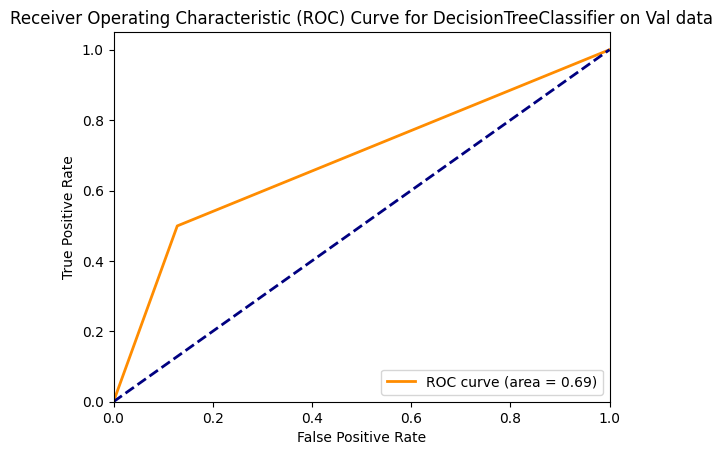

In [140]:
compute_auroc_and_build_roc(dt_model, X_val, val_targets, 'DecisionTreeClassifier on Val data')


The model has learned the training examples perfectly, but does not generalize well to previously unseen examples. 

This phenomenon is called `overfitting` and we will try to reduce its effect


We can visualize the structure of the resulting decision tree we trained using the `plot_tree` function from scikit-learn and see it's depth.


In [29]:
from sklearn.tree import plot_tree, export_text

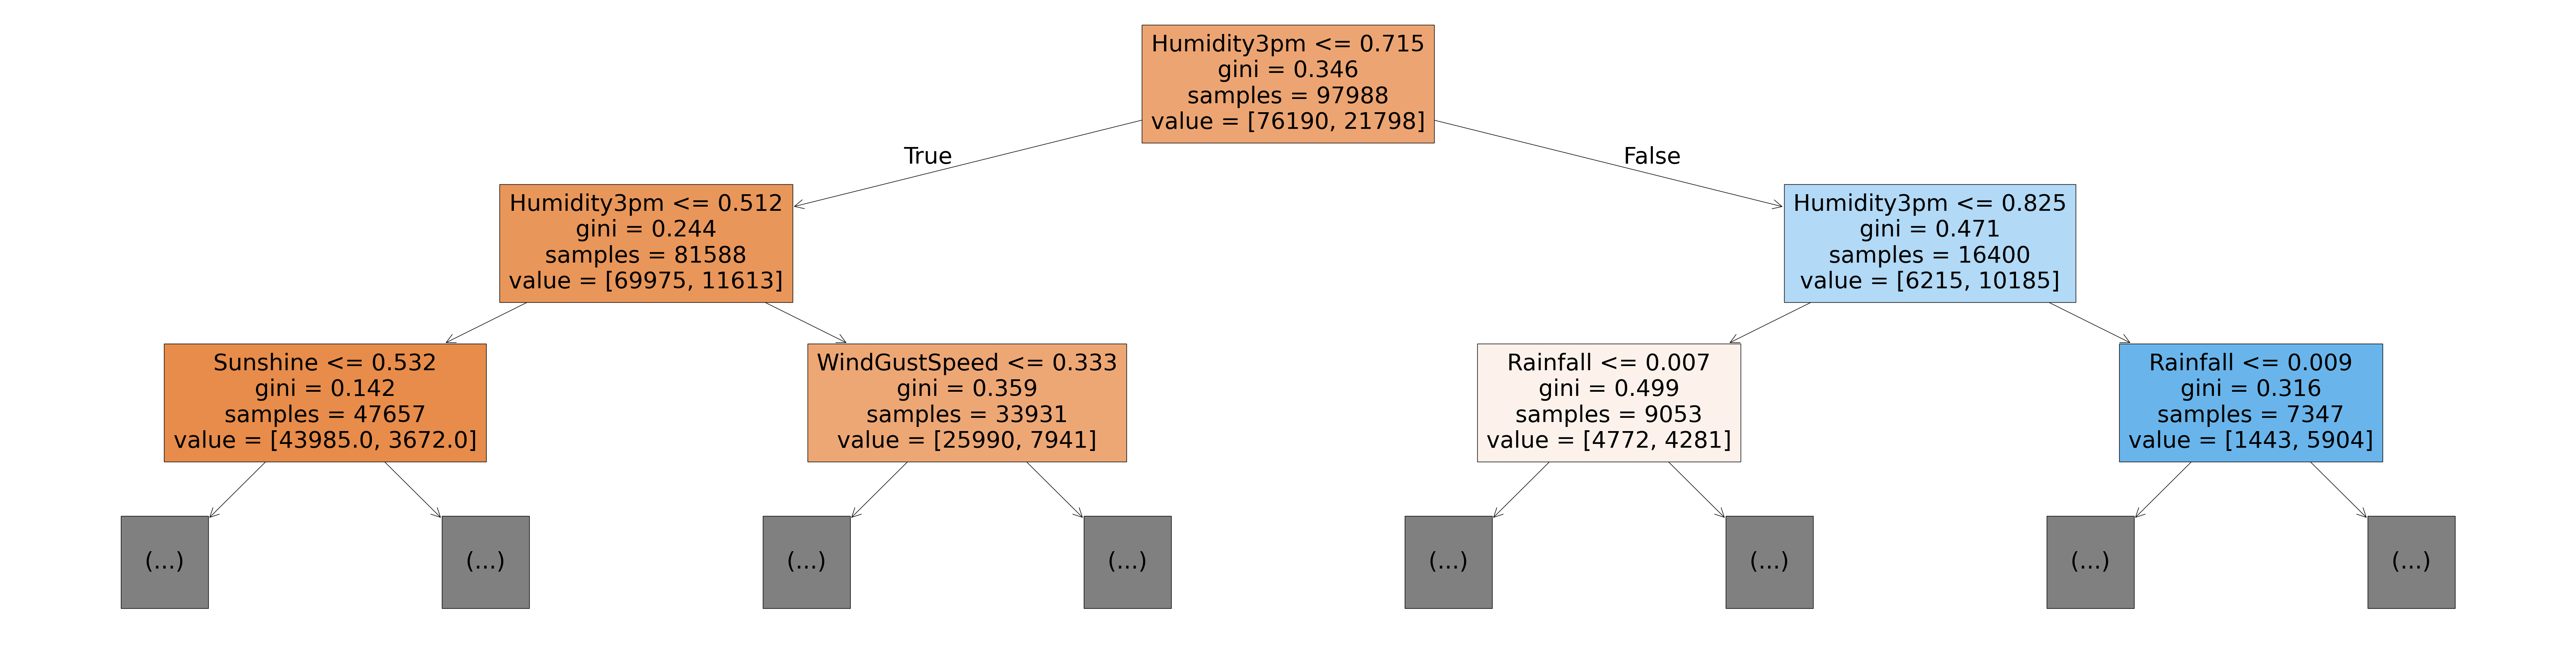

In [30]:
plt.figure(figsize=(80,20))
plot_tree(dt_model, feature_names=X_train.columns, max_depth=2, filled=True);

In [31]:
dt_model.tree_.max_depth

51

In [32]:
# Visualize tree as text
tree_text = export_text(dt_model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- truncated branch of depth 27
|   |   |--- Sunshine >  0.53
|   |   |   |--- truncated branch of depth 37
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- truncated branch of depth 49
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- truncated branch of depth 31
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 31
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 31
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- truncated branch of depth 26
|   |   |--- Rainfall >  0.01
|   |   |   |--- truncated branch of depth 24



#### Feature importance
Feature importance is a measure of how much a feature contributes to the model's predictions. 

Based on the calculation of the gini index, the decision tree assigns an 'importance' value to each feature. These values can be used to interpret the results provided by the decision tree


In [33]:
dt_model.feature_importances_.round(2)


array([0.04, 0.03, 0.04, 0.02, 0.05, 0.06, 0.03, 0.03, 0.04, 0.28, 0.04,
       0.06, 0.01, 0.02, 0.04, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

 
Let's turn this into a DataFrame and visualize the most important features.


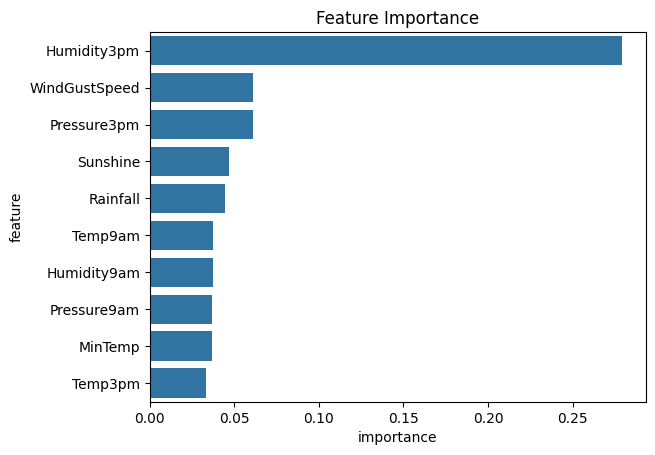

In [34]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [184]:
results_df = results_df._append({'model': 'DecisionTreeClassifier',
                    'f1_score_train': 1.0, 'f1_score_val': 0.5, 
                    'roc_auc_train' : 1.0, 'roc_auc_val' : 0.69, 
                    'accuracy_train' : 0.99, 'accuracy_val' : 0.79}, ignore_index = True)


 
####  Hyperparameter Tuning and Overfitting
As we saw in the previous section model memorized all the training examples, resulting in 100% accuracy on the training set, while the accuracy on the validation set was only slightly better than the baseline model. This phenomenon is called overfitting, and in now we will look at some strategies to reduce it.
The `DecisionTreeClassifier` takes several arguments, some of which can be changed to reduce overfitting


Let's use `RandomizedSearchCV` to find the best  parameters using `f1 score` as scoring parameter

In [36]:
from sklearn.model_selection import RandomizedSearchCV

tree_model = DecisionTreeClassifier(random_state=42)

params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 60),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}


dt_random = RandomizedSearchCV(tree_model, 
                                params_dt, scoring='f1', 
                                random_state=42, 
                                cv=3, 
                                n_jobs=5, 
                                n_iter=40)

In [37]:
dt_random.fit(X_train, train_targets)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40, n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1')

In [38]:
dt_random.best_params_

{'splitter': 'best',
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 43,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'entropy'}

In [39]:
dt_random_search_best = dt_random.best_estimator_

Let's evaluate new model to see how if it can generalize better

In [40]:
print('Training acc:', dt_random_search_best.score(X_train, train_targets))
print('Training acc:', dt_random_search_best.score(X_val, val_targets))
print('Training acc:', dt_random_search_best.score(X_test, test_targets))

Training acc: 0.7927807486631016
Training acc: 0.799344607642343
Training acc: 0.7873978996499417


In [41]:
get_f1_score(dt_random_search_best, X_train, train_targets, 'Training')
get_f1_score(dt_random_search_best, X_val, val_targets, 'Validation')
get_f1_score(dt_random_search_best, X_test, test_targets, 'Test')

F1 score Training: 0.36
F1 score Validation: 0.28
F1 score Test: 0.35


AUROC for DecisionTreeClassifier on Training data: 0.74


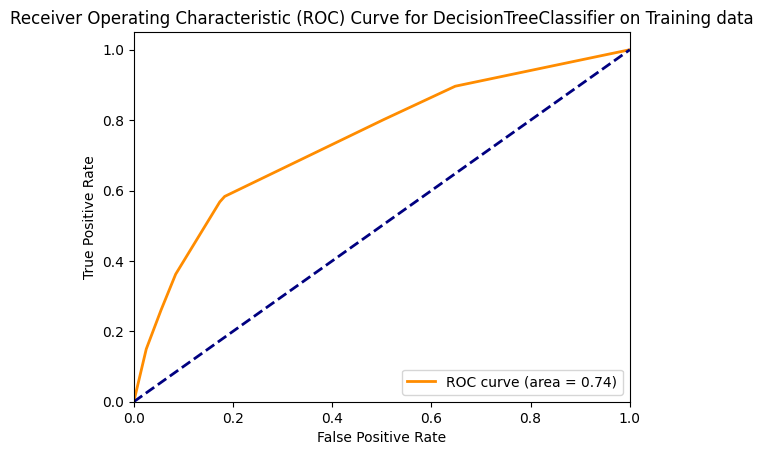

In [137]:
compute_auroc_and_build_roc(dt_random_search_best, X_train, train_targets, 'DecisionTreeClassifier on Training data')

AUROC for DecisionTreeClassifier on Validation data: 0.73


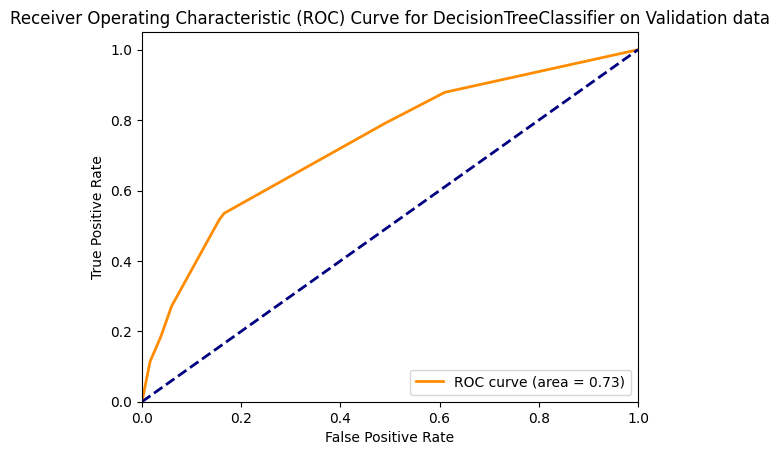

In [138]:
compute_auroc_and_build_roc(dt_random_search_best, X_val, val_targets, 'DecisionTreeClassifier on Validation data')

 
Although the accuracy of the model on the training data decreased, the accuracy of the model on the validation data increased significantly.

Let's look at the structure of this model

[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\nentropy = 0.765\nsamples = 97988\nvalue = [76190, 21798]\nclass = No'),
 Text(0.25, 0.625, 'Pressure3pm <= 0.529\nentropy = 0.613\nsamples = 76002\nvalue = [64504, 11498]\nclass = No'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Humidity3pm <= 0.595\nentropy = 0.815\nsamples = 17758\nvalue = [13276, 4482]\nclass = No'),
 Text(0.0625, 0.125, 'entropy = 0.63\nsamples = 13077\nvalue = [11007, 2070]\nclass = No'),
 Text(0.1875, 0.125, 'entropy = 0.999\nsamples = 4681\nvalue = [2269, 2412]\nclass = Yes'),
 Text(0.375, 0.375, 'Humidity9am <= 0.675\nentropy = 0.531\nsamples = 58244\nvalue = [51228, 7016]\nclass = No'),
 Text(0.3125, 0.125, 'entropy = 0.394\nsamples = 29076\nvalue = [26816, 2260]\nclass = No'),
 Text(0.4375, 0.125, 'entropy = 0.642\nsamples = 29168\nvalue = [24412, 4756]\nclass = No'),
 Text(0.75, 0.625, 'Pressure9am <= 0.564\nentropy = 0.997\nsamples = 21986\nvalue = [11686.0, 10300.0]\nclass = No'),
 Text(0.625, 0.75, '  False

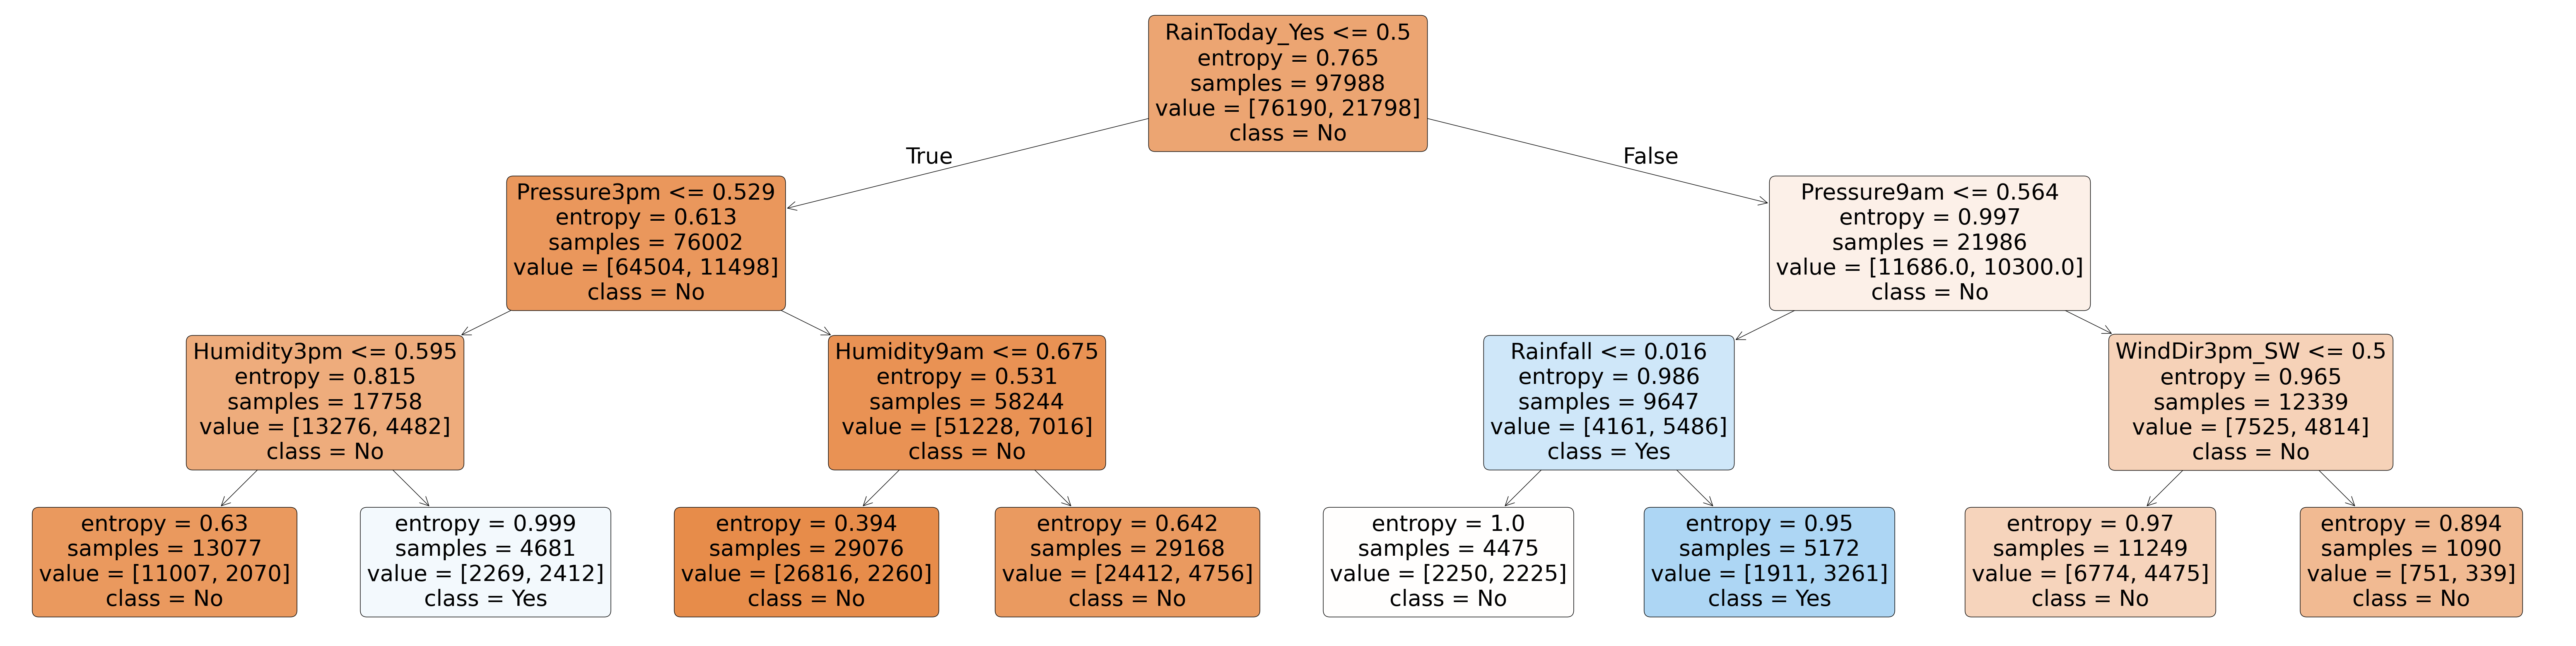

In [44]:
plt.figure(figsize=(80,20))
plot_tree(dt_random_search_best, feature_names=X_train.columns, filled=True, rounded=True, class_names=dt_random_search_best.classes_)

In [45]:
dt_random_search_best.max_depth

3

In [185]:
results_df = results_df._append({'model': 'DecisionTreeClassifier + RandomSearch',
                    'f1_score_train': 0.36, 'f1_score_val': 0.28, 
                    'roc_auc_train' : 0.74, 'roc_auc_val' : 0.73, 
                    'accuracy_train' : 0.79, 'accuracy_val' : 0.79}, ignore_index = True)

### XGBoost

XGBoost, or Extreme Gradient Boosting, is a highly efficient and powerful algorithm that excels in classification tasks due to its ability to capture complex patterns in data while preventing overfitting. 

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


In [53]:
train_targets_bool = train_targets.apply(lambda x: x=='Yes')
val_targets_bool = val_targets.apply(lambda x: x=='Yes')
test_targets_bool = test_targets.apply(lambda x: x=='Yes')


In [60]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=False,  
    device='cuda'
)

xgb_clf.fit(X_train, train_targets_bool)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print('Train------------------------------------')
print(classification_report(train_targets_bool, train_pred, digits=4))
print('Val------------------------------------')
print(classification_report(val_targets_bool, val_pred, digits=4))

Train------------------------------------
              precision    recall  f1-score   support

       False     0.8626    0.9560    0.9069     76190
        True     0.7525    0.4679    0.5771     21798

    accuracy                         0.8474     97988
   macro avg     0.8076    0.7120    0.7420     97988
weighted avg     0.8381    0.8474    0.8335     97988

Val------------------------------------
              precision    recall  f1-score   support

       False     0.8598    0.9615    0.9078     13511
        True     0.7374    0.4080    0.5254      3578

    accuracy                         0.8456     17089
   macro avg     0.7986    0.6848    0.7166     17089
weighted avg     0.8342    0.8456    0.8277     17089



AUROC for XGBoost on Train data: 0.87


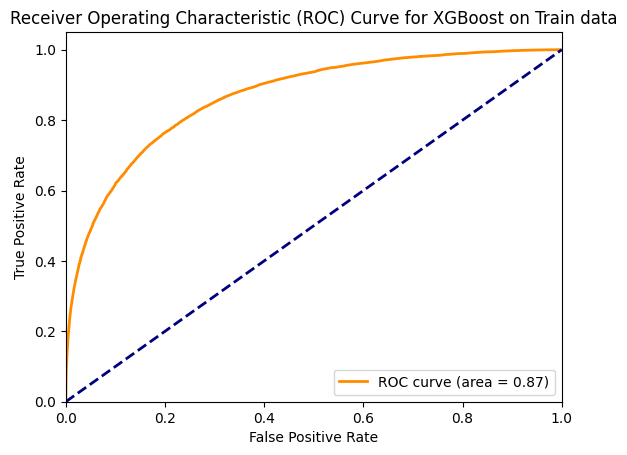

In [135]:
compute_auroc_and_build_roc(xgb_clf, X_train, train_targets, 'XGBoost on Train data')

AUROC for XGBoost on Val data: 0.86


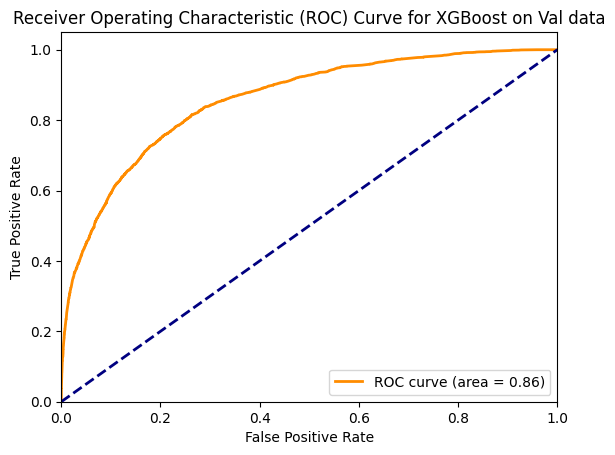

In [136]:
compute_auroc_and_build_roc(xgb_clf, X_val, val_targets, 'XGBoost on Val data')

In [186]:
results_df = results_df._append({'model': 'XGBoost',
                    'f1_score_train': 0.74, 'f1_score_val': 0.71, 
                    'roc_auc_train' : 0.87, 'roc_auc_val' : 0.86, 
                    'accuracy_train' : 0.84, 'accuracy_val' : 0.84}, ignore_index = True)

### LightGBM


In [66]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
)

lgb_clf.fit(X_train, train_targets_bool, eval_set=[(X_val, val_targets_bool)])

train_pred = lgb_clf.predict(X_train)
val_pred = lgb_clf.predict(X_val)

In [132]:
print('Train------------------------------------')
print(classification_report(train_targets_bool, train_pred, digits=4))
print('Val------------------------------------')
print(classification_report(val_targets_bool, val_pred, digits=4))

Train------------------------------------
              precision    recall  f1-score   support

       False     0.8665    0.9558    0.9090     76190
        True     0.7586    0.4854    0.5920     21798

    accuracy                         0.8512     97988
   macro avg     0.8126    0.7206    0.7505     97988
weighted avg     0.8425    0.8512    0.8385     97988

Val------------------------------------
              precision    recall  f1-score   support

       False     0.8631    0.9640    0.9108     13511
        True     0.7568    0.4226    0.5423      3578

    accuracy                         0.8507     17089
   macro avg     0.8099    0.6933    0.7265     17089
weighted avg     0.8408    0.8507    0.8336     17089



AUROC for LGBM on Train data: 0.87


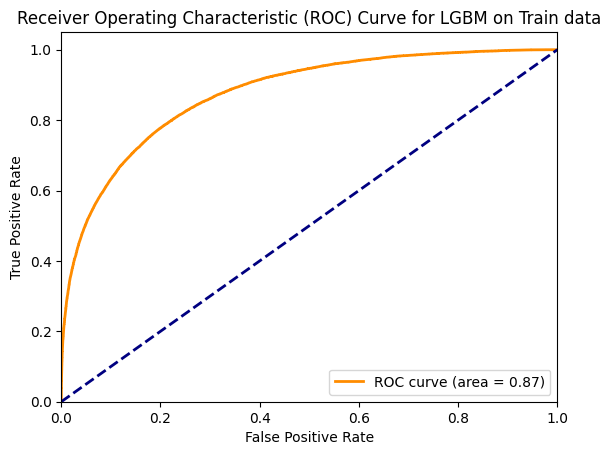

In [133]:
compute_auroc_and_build_roc(lgb_clf, X_train, train_targets, 'LGBM on Train data')

AUROC for LGBM on Val data: 0.86


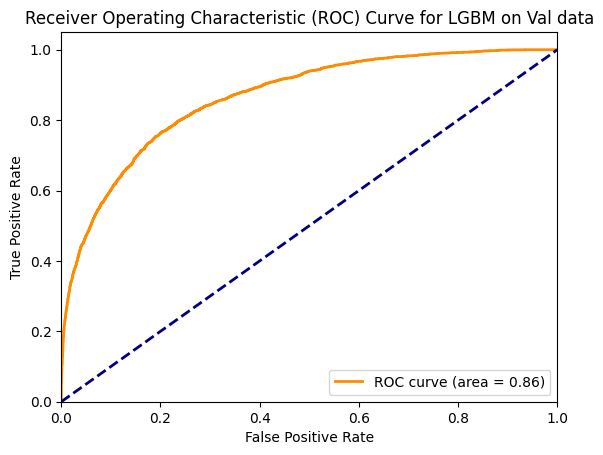

In [ ]:
compute_auroc_and_build_roc(lgb_clf, X_val, val_targets, 'LGBM on Val data')

In [187]:
results_df = results_df._append({'model': 'LGBM',
                    'f1_score_train': 0.75, 'f1_score_val': 0.72, 
                    'roc_auc_train' : 0.87, 'roc_auc_val' : 0.86, 
                    'accuracy_train' : 0.85, 'accuracy_val' : 0.85}, ignore_index = True)

### Hyperparameter Optimization with Hyperopt

Hyperopt is a powerful Python library for hyperparameter tuning that employs Bayesian optimization to efficiently search for the best parameters

Let's try to find better parametes for XGBoost and LightGBM models

#### XGBoost with Hyperopt

In [62]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Minimum sum of weights of all samples required in a leaf node
        subsample=params['subsample'],  # Fraction of samples used to build each tree
        colsample_bytree=params['colsample_bytree'],  # Fraction of features used when building each tree
        gamma=params['gamma'],  # Minimum loss reduction required to make a split
        reg_alpha=params['reg_alpha'],  # L1 regularization term (Lasso)
        reg_lambda=params['reg_lambda'],  # L2 regularization term (Ridge)
        # enable_categorical=True,
        # use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets_bool,
        eval_set=[(X_val, val_targets_bool)],
        verbose=False)
    pred = clf.predict(X_val)
    # accuracy = accuracy_score(val_targets_bool, pred)
    f1 = f1_score(val_targets_bool, pred, average='macro')

    return {'loss': -f1, 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Converting hyperparameter values to final types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Best hyperparameters: ", best)

# Training the final model with the best hyperparameters
final_clf_xgb = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf_xgb.fit(X_train, train_targets_bool)

final_pred_val = final_clf_xgb.predict(X_val)
final_pred_train = final_clf_xgb.predict(X_train)
final_pred_test = final_clf_xgb.predict(X_test)


final_valf1 = f1_score(val_targets_bool, final_pred_val, average='macro')
final_trainf1 = f1_score(train_targets_bool, final_pred_train, average='macro')
final_testf1 = f1_score(test_targets_bool, final_pred_test, average='macro')


100%|██████████| 20/20 [00:37<00:00,  1.88s/trial, best loss: -0.7669148863179313]
Best hyperparameters:  {'colsample_bytree': 0.6198105003056877, 'gamma': 0.23195568978710895, 'learning_rate': 0.1358176429362563, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 125, 'reg_alpha': 0.34986979655749173, 'reg_lambda': 0.8006438830627234, 'subsample': 0.7273176000908341}


c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:23] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [144]:
print("F1 on train set: {:.4f}".format(final_trainf1))
print("F1 on validation set: {:.4f}".format(final_valf1))
print("F1 on test set: {:.4f}".format(final_testf1))


F1 on train set: 0.8182
F1 on validation set: 0.7669
F1 on test set: 0.7700


AUROC for XGBoost with Hyperopt on Train data: 0.93


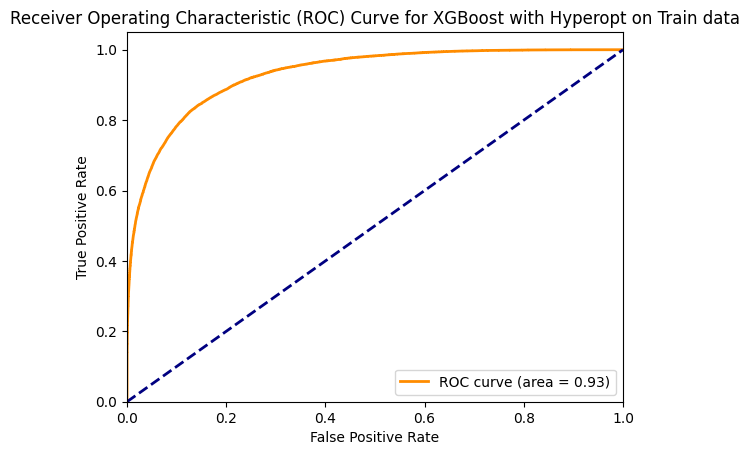

In [ ]:
compute_auroc_and_build_roc(final_clf_xgb, X_train, train_targets, 'XGBoost with Hyperopt on Train data')

AUROC for XGBoost with Hyperopt on Validation data: 0.89


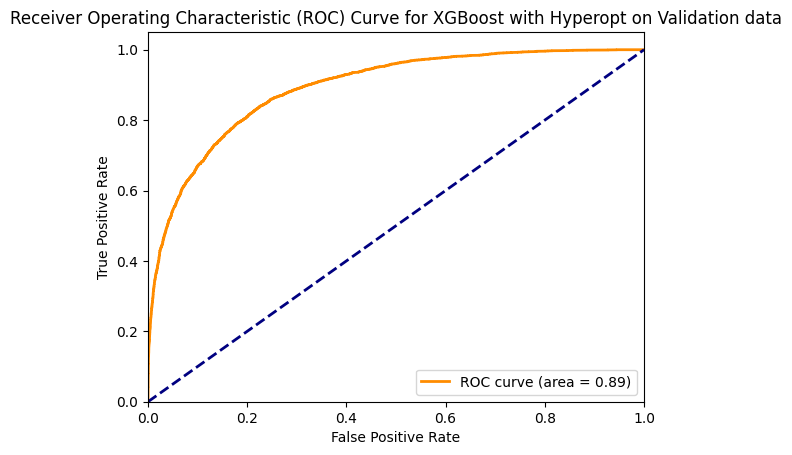

In [ ]:
compute_auroc_and_build_roc(final_clf_xgb, X_val, val_targets, 'XGBoost with Hyperopt on Validation data')

In [188]:
results_df = results_df._append({'model': 'XGBoost + Hyperopt',
                    'f1_score_train': 0.81, 'f1_score_val': 0.76, 
                    'roc_auc_train' : 0.93, 'roc_auc_val' : 0.89}, ignore_index = True)

#### LGBM with Hyperopt


In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Number of trees in the ensemble (number of boosting iterations)
        learning_rate=params['learning_rate'],  # The factor by which the contribution of each added tree is reduced
        max_depth=int(params['max_depth']),  # Maximum depth of each tree
        num_leaves=int(params['num_leaves']),  # Maximum number of leaves allowed for each tree
        min_child_weight=params['min_child_weight'],  # Minimum sum of weights of all samples required in a leaf node
        subsample=params['subsample'],  # Fraction of samples used to build each tree
        colsample_bytree=params['colsample_bytree'],  # Fraction of features used when building each tree
        reg_alpha=params['reg_alpha'],  # L1 regularization term (Lasso)
        reg_lambda=params['reg_lambda'],  # L2 regularization term (Ridge)
        min_split_gain=params['min_split_gain'],  # Minimum loss reduction required to make a split
        # cat_feature=cat_feature_indexes  # Indices of categorical features
    )

    clf.fit(X_train, train_targets_bool, eval_set=[(X_val, val_targets_bool)])
    pred = clf.predict(X_val)
    # accuracy = accuracy_score(val_targets, pred)
    f1 = f1_score(val_targets_bool, pred, average='macro')

    return {'loss': -f1, 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # Added minimum loss reduction for split
}

# Optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Converting hyperparameter values to final types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Best hyperparameters: ", best)

# Training the final model with the best hyperparameters
final_clf_lgbm = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    # cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf_lgbm.fit(X_train, train_targets_bool, eval_set=[(X_val, val_targets_bool)])

final_pred_val = final_clf_lgbm.predict(X_val)
final_pred_train = final_clf_lgbm.predict(X_train)
final_pred_test = final_clf_lgbm.predict(X_test)


final_valf1 = f1_score(val_targets_bool, final_pred_val, average='macro')
final_trainf1 = f1_score(train_targets_bool, final_pred_train, average='macro')
final_testf1 = f1_score(test_targets_bool, final_pred_test, average='macro')


In [148]:
print("F1 on train set: {:.4f}".format(final_trainf1))
print("F1 on validation set: {:.4f}".format(final_valf1))
print("F1 on test set: {:.4f}".format(final_testf1))

F1 on train set: 0.8200
F1 on validation set: 0.7650
F1 on test set: 0.7709


[LightGBM] [Warning] Unknown parameter: missing
AUROC for LightGBM with Hyperopt on Train data: 0.93


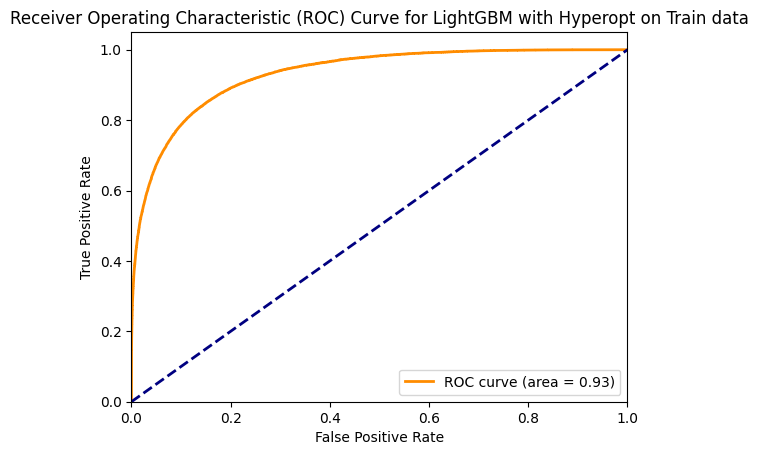

In [ ]:

compute_auroc_and_build_roc(final_clf_lgbm, X_train, train_targets, 'LightGBM with Hyperopt on Train data')

[LightGBM] [Warning] Unknown parameter: missing
AUROC for LightGBM with Hyperopt on Validation data: 0.89


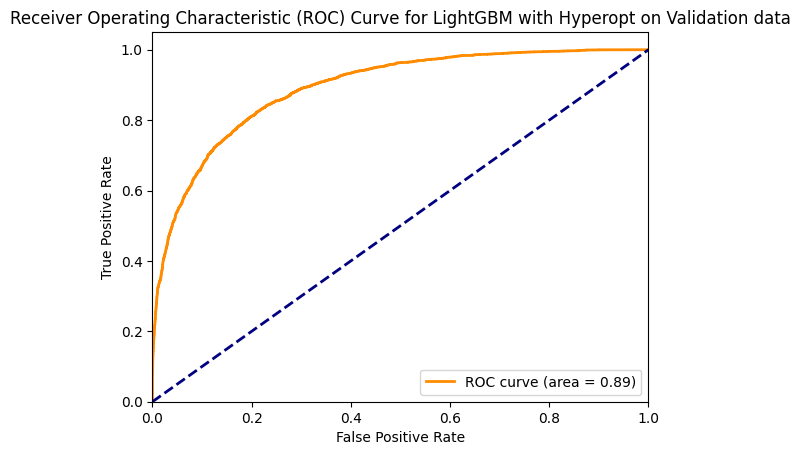

In [ ]:
compute_auroc_and_build_roc(final_clf_lgbm, X_val, val_targets, 'LightGBM with Hyperopt on Validation data')

In [189]:
results_df = results_df._append({'model': 'LGBM + Hyperopt',
                    'f1_score_train': 0.82, 'f1_score_val': 0.76, 
                    'roc_auc_train' : 0.93, 'roc_auc_val' : 0.89}, ignore_index = True)

Now let's look at results from all experiments to find the model with best performance

In [192]:
results_df

,model,f1_score_train,f1_score_val,roc_auc_train,roc_auc_val,accuracy_train,accuracy_val
0,Logistic Regression,0.61,0.57,0.88,0.87,0.85,0.85
1,DecisionTreeClassifier,1.00,0.50,1.00,0.69,0.99,0.79
2,DecisionTreeClassifier + RandomSearch,0.36,0.28,0.74,0.73,0.79,0.79
3,XGBoost,0.74,0.71,0.87,0.86,0.84,0.84
4,LGBM,0.75,0.72,0.87,0.86,0.85,0.85
5,XGBoost + Hyperopt,0.81,0.76,0.93,0.89,NaN,NaN
6,LGBM + Hyperopt,0.82,0.76,0.93,0.89,NaN,NaN


### Conclusions

In this project, we evaluated various classification models to determine their effectiveness in predicting outcomes.

1. **Logistic Regression**: 
   - Lowest performance with ROC AUC scores of 0.61 (train) and 0.57 (val), indicating poor pattern capture.

2. **Decision Tree Classifier**: 
   - Perfect ROC AUC of 1.00 on the training set but drops to 0.50 on validation, indicating severe overfitting.

3. **Decision Tree + RandomSearch**: 
   - Approach addressed overfitting issues but resulted in lower performance, yielding ROC AUC scores of 0.36 (train) and 0.28 (val), suggesting that the hyperparameter tuning did not enhance the model's predictive capability.

4. **XGBoost and LGBM**: 
   - Both models show good performance with ROC AUC scores around 0.74 to 0.75 on validation, indicating effective generalization.

5. **XGBoost + Hyperopt and LGBM + Hyperopt**: 
   - Excellent scores of 0.81 and 0.82, respectively, showing significant improvement from hyperparameter tuning.

6. **Overfitting Concerns**: 
   - High training ROC AUC scores (0.93) for Hyperopt models raise overfitting concerns, but validation scores suggest good generalization.


 
Using XGBoost and LGBM with Hyperopt leads to significant performance improvements, making them the preferred choices for this classification task.

Let's save training result to use in future

In [ ]:
import joblib

models = {
    'log_reg': lg_model,
    'dt': dt_model,
    'dt_rand': dt_random_search_best,
    'xgb': xgb_clf,
    'lgbm': lgb_clf,
    'hp_xgb': final_clf_xgb,
    'hp_lgbm': final_clf_lgbm
}

joblib.dump(models, 'models/trained_models.joblib')

['models/trained_models.joblib']